In [94]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [95]:
iris = load_iris()

df = pd.DataFrame(data=iris.data, columns=iris.feature_names)

In [96]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

In [97]:
df['target'] = iris.target_names[iris.target]

In [98]:
df.head(10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
5,5.4,3.9,1.7,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa
7,5.0,3.4,1.5,0.2,setosa
8,4.4,2.9,1.4,0.2,setosa
9,4.9,3.1,1.5,0.1,setosa


In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


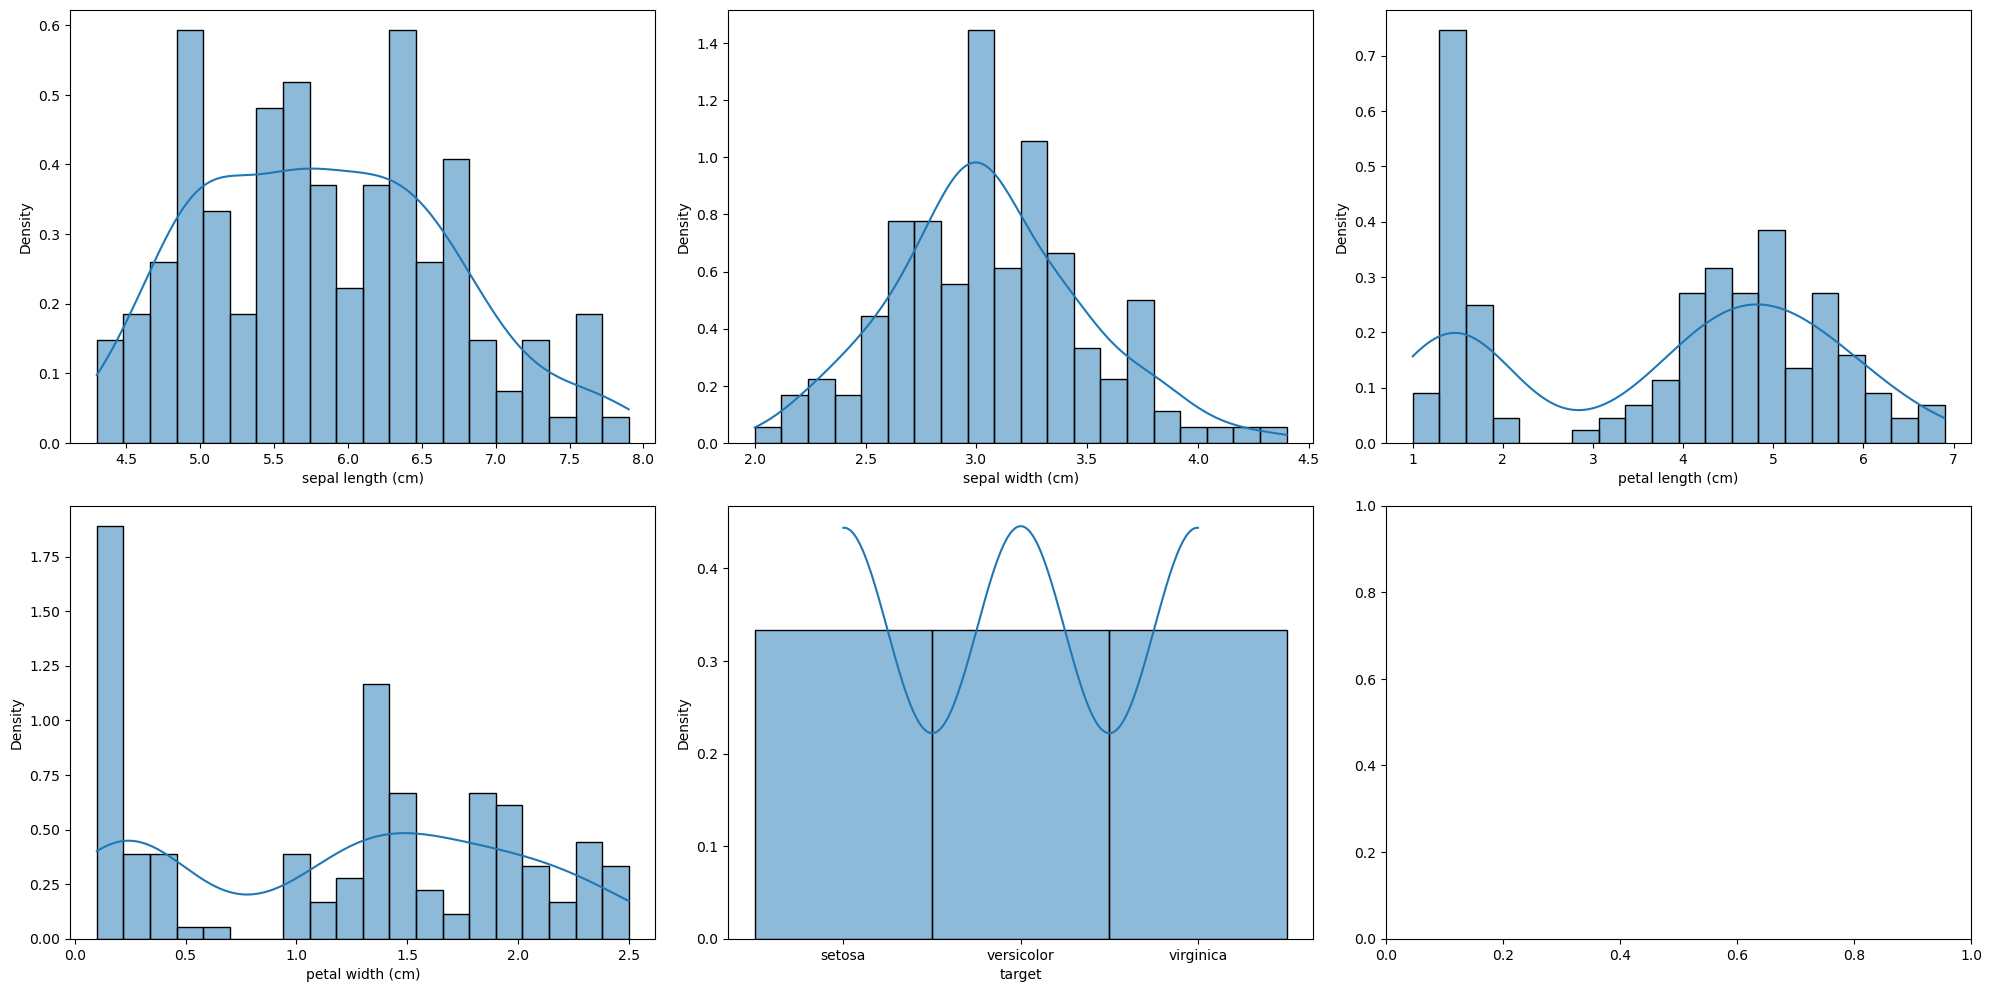

In [100]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes_flattened = axes.reshape(-1)

bins = 20

for idx, column in enumerate(df):
    ax = axes_flattened[idx]
    sns.histplot(data=df,
                 x=column,
                 bins=bins,
                 stat='density',
                 kde=True,
                 ax=ax)
fig.tight_layout(pad=1.0)

In [101]:
X = df.drop(columns=['target']).copy()
y = df['target'].copy()

<Axes: >

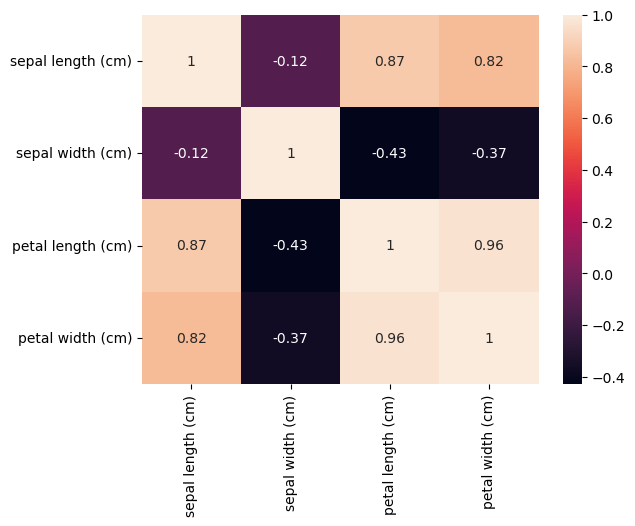

In [102]:
sns.heatmap(X.corr(), annot=True)

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

encoder = LabelEncoder()

y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [106]:
def train(net: torch.nn.Module,
          train_loader: DataLoader,
          optimizer : optim.Optimizer,
          num_epochs: int,
          device: str = 'cuda') -> list:
    
    torch.cuda.empty_cache()
    loss_function = torch.nn.CrossEntropyLoss()
    acc_history = []

    with tqdm(total=len(train_loader)*num_epochs, position=0, leave=True) as pbar:

        for epoch in range(num_epochs):
            running_loss = 0.0
            correct = 0
            total = 0 
            
            for batch_num, (inputs, labels) in enumerate(train_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()

                outputs = net(inputs)
                loss = loss_function(outputs, labels)
              
                loss.backward()

                optimizer.step()

                running_loss += loss.item()

                _, predicted = outputs.max(1)
                batch_total = labels.size(0)
                batch_correct = predicted.eq(labels).sum().item()
                batch_acc = batch_correct/batch_total
                
                pbar.set_description("Epoch: %d, Batch: %2d, Loss: %.2f, Acc: %.2f" % (epoch, batch_num, running_loss, batch_acc))
                pbar.update()

                total += batch_total
                correct += batch_correct

            acc = correct/total 
            acc_history.append(acc)

        pbar.close()

    return acc_history


In [107]:
def print_history(history: list, title: str = "Accurancy"):
    plt.figure(figsize=(7, 4))
    plt.plot(history)
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

In [108]:
def evaluate_acc(net: nn.Module,
                 test_loader: DataLoader,
                 device: str = 'cuda'):

    total = 0
    correct = 0
    
    for batch_num, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = net(inputs)        
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
    acc = correct/total
    print(f"accurancy: {acc}")

In [109]:
class IrisNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(IrisNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU()
        )
        self.layer3 = nn.Sequential(
            nn.Linear(64, 3),
            nn.Softmax()
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

  0%|          | 0/600 [00:00<?, ?it/s]/home/victor/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Epoch: 19, Batch: 29, Loss: 24.30, Acc: 0.50: 100%|██████████| 600/600 [00:00<00:00, 702.13it/s]


accurancy: 0.8


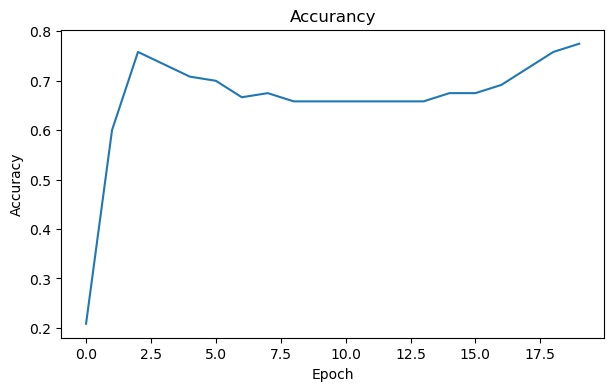

In [ ]:
NUM_EPOCHS = 20
LR = 0.01

net = IrisNet(input_size=4, num_classes=3).to(device)
optimizer = optim.SGD(net.parameters(), lr=LR)

print_history(train(net, train_loader, optimizer, num_epochs=NUM_EPOCHS))
evaluate_acc(net, test_loader)